In [1]:
import mne
import os

# Directory where the EDF files are stored
data_dir = r'eeg-during-mental-arithmetic-tasks-1.0.0'

# Load the EEG data for one subject
subject_id = "Subject00"
file_rest = os.path.join(data_dir, f"{subject_id}_1.edf")
file_task = os.path.join(data_dir, f"{subject_id}_2.edf")

# Load the data using MNE
raw_rest = mne.io.read_raw_edf(file_rest, preload=True)
raw_task = mne.io.read_raw_edf(file_task, preload=True)

# Print basic information about the loaded data
print(raw_rest.info)
print(raw_task.info)


Extracting EDF parameters from C:\Users\prave\Desktop\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\prave\Desktop\eeg-during-mental-arithmetic-tasks-1.0.0\Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_d

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


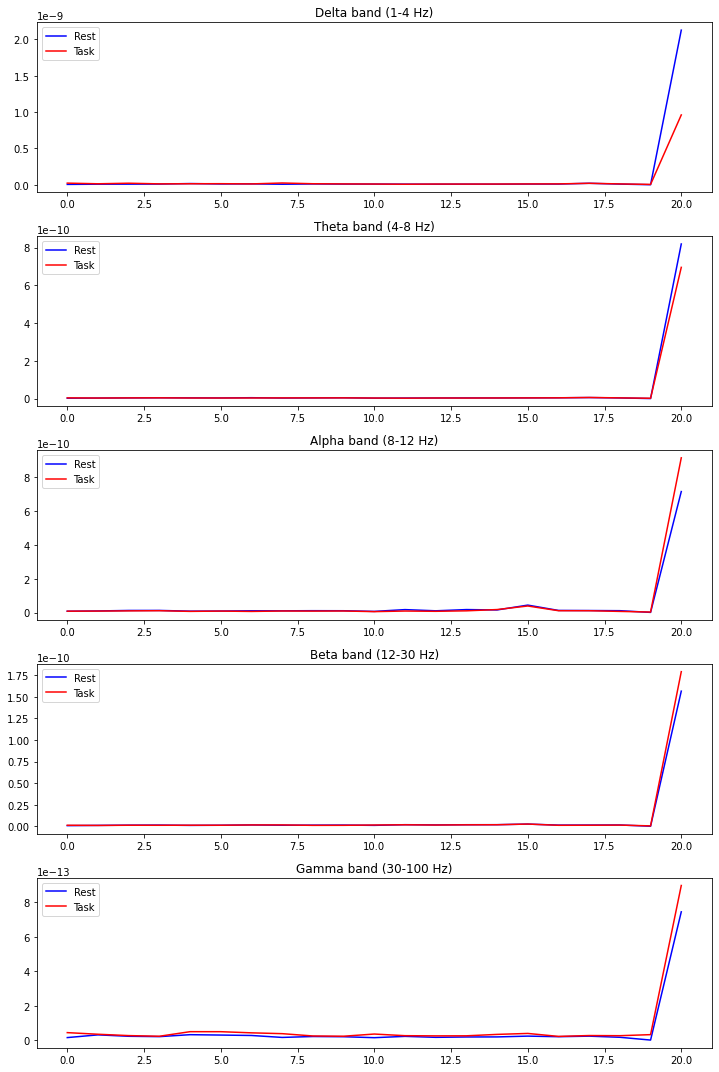

Delta band: Rest mean = 1.1098073112978622e-10, Task mean = 5.90984464656473e-11
Theta band: Rest mean = 4.243586159484274e-11, Task mean = 3.654851070010193e-11
Alpha band: Rest mean = 4.6217049997121295e-11, Task mean = 5.36617373432274e-11
Beta band: Rest mean = 8.82424100875858e-12, Task mean = 9.902899949449655e-12
Gamma band: Rest mean = 5.60935859810025e-14, Task mean = 7.457442628684502e-14


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define frequency bands
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

# Function to compute PSD for a given raw data
def compute_band_psd(raw, bands):
    psd_obj = raw.compute_psd(method='welch', fmin=1, fmax=100, tmin=0, tmax=None)
    psds = psd_obj.get_data()
    freqs = psd_obj.freqs
    psd_band = {band: np.mean(psds[:, (freqs >= fmin) & (freqs < fmax)], axis=1) for band, (fmin, fmax) in bands.items()}
    return psd_band

# Compute PSD for both rest and task states
psd_rest = compute_band_psd(raw_rest, bands)
psd_task = compute_band_psd(raw_task, bands)

# Plot the PSD for both states
def plot_psd(psd_rest, psd_task, bands):
    fig, axes = plt.subplots(len(bands), 1, figsize=(10, 15))
    for i, (band, (fmin, fmax)) in enumerate(bands.items()):
        axes[i].plot(psd_rest[band], label='Rest', color='blue')
        axes[i].plot(psd_task[band], label='Task', color='red')
        axes[i].set_title(f'{band} band ({fmin}-{fmax} Hz)')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_psd(psd_rest, psd_task, bands)

# Compare the PSDs and summarize findings
for band in bands.keys():
    print(f"{band} band: Rest mean = {np.mean(psd_rest[band])}, Task mean = {np.mean(psd_task[band])}")


In [3]:
# the following two lines are needed in order to execute the magic word 'capture'
# it function is to capture the cell output and hides it 
# used to hide the unnecessary info from printing 
# it has no connection to this project

import nest_asyncio
nest_asyncio.apply()

In [4]:
# extract featrues from each .edf file

%%capture
import os
import numpy as np
import pandas as pd
import mne

# Define a function to extract features for all subjects
def extract_features(data_dir, bands):
    features = []
    labels = []
    for subject_id in range(36):
        file_rest = os.path.join(data_dir, f"Subject{subject_id:02d}_1.edf")
        file_task = os.path.join(data_dir, f"Subject{subject_id:02d}_2.edf")
        
        raw_rest = mne.io.read_raw_edf(file_rest, preload=True)
        raw_task = mne.io.read_raw_edf(file_task, preload=True)
        
        psd_rest = compute_band_psd(raw_rest, bands)
        psd_task = compute_band_psd(raw_task, bands)
        
        feature_rest = [np.mean(psd_rest[band]) for band in bands.keys()]
        feature_task = [np.mean(psd_task[band]) for band in bands.keys()]
        
        features.append(feature_rest)
        features.append(feature_task)
        
        labels.append(0)  # Label for rest state
        labels.append(1)  # Label for task state

    return np.array(features), np.array(labels)

# Extract features and labels
data_dir = r'eeg-during-mental-arithmetic-tasks-1.0.0'  # Replace with your actual data directory
features, labels = extract_features(data_dir, bands)

# Convert to DataFrame for easier manipulation
df_features = pd.DataFrame(features, columns=bands.keys())
df_labels = pd.Series(labels, name='Label')

# Combine features and labels into one DataFrame
df = pd.concat([df_features, df_labels], axis=1)

print(df.head())


In [5]:
# extracted features format with labels
print(df.head())

          Delta         Theta         Alpha          Beta         Gamma  Label
0  1.109807e-10  4.243586e-11  4.621705e-11  8.824241e-12  5.609359e-14      0
1  5.909845e-11  3.654851e-11  5.366174e-11  9.902900e-12  7.457443e-14      1
2  5.094467e-11  2.106973e-11  1.479517e-11  3.421524e-12  1.403730e-13      0
3  6.082792e-11  1.518508e-11  1.093623e-11  3.033246e-12  1.995199e-13      1
4  1.675067e-11  3.398685e-12  7.427257e-12  1.489205e-12  8.460580e-14      0


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Separate features and labels
X = df_features.values
y = df_labels.values

In [7]:
# feature values before scalling
print(X[:5])

[[1.10980731e-10 4.24358616e-11 4.62170500e-11 8.82424101e-12
  5.60935860e-14]
 [5.90984465e-11 3.65485107e-11 5.36617373e-11 9.90289995e-12
  7.45744263e-14]
 [5.09446702e-11 2.10697331e-11 1.47951700e-11 3.42152440e-12
  1.40373011e-13]
 [6.08279224e-11 1.51850845e-11 1.09362323e-11 3.03324640e-12
  1.99519937e-13]
 [1.67506667e-11 3.39868476e-12 7.42725736e-12 1.48920473e-12
  8.46057961e-14]]


In [8]:
# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# feature values after scalling
print(X_scaled[:5])

[[ 0.55799906  0.68918825  1.38633018  0.01140748 -0.83207379]
 [-0.15454235  0.38629989  1.88385632  0.19582919 -0.66395302]
 [-0.26652476 -0.41004157 -0.71358433 -0.91231196 -0.06538127]
 [-0.13079006 -0.7127909  -0.97147594 -0.97869708  0.47268013]
 [-0.73613868 -1.31916945 -1.20597965 -1.24268673 -0.57269734]]


In [10]:
# labels
print(y)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (57, 5)
X_test shape: (15, 5)
y_train shape: (57,)
y_test shape: (15,)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Reshape the data to fit the input shape of EEGNet
X_train_eegnet = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_eegnet = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

In [17]:
# Define the EEGNet model
def create_eegnet_model(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (1, input_shape[1]), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(1, 1)) 
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (1, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D(1, 1)) 
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Create and train the EEGNet model
eegnet_model = create_eegnet_model((X_train_eegnet.shape[1], 1, 1))
eegnet_model.fit(X_train_eegnet, y_train, epochs=30, batch_size=16, validation_data=(X_test_eegnet, y_test))

Epoch 1/30
4/4 [==============================] - 3s 168ms/step - loss: 0.9210 - accuracy: 0.5439 - val_loss: 0.6960 - val_accuracy: 0.6000
Epoch 2/30
4/4 [==============================] - 0s 28ms/step - loss: 0.8339 - accuracy: 0.5263 - val_loss: 0.7065 - val_accuracy: 0.4000
Epoch 3/30
4/4 [==============================] - 0s 34ms/step - loss: 0.7454 - accuracy: 0.5088 - val_loss: 0.7166 - val_accuracy: 0.5333
Epoch 4/30
4/4 [==============================] - 0s 46ms/step - loss: 0.6770 - accuracy: 0.5965 - val_loss: 0.7169 - val_accuracy: 0.3333
Epoch 5/30
4/4 [==============================] - 0s 29ms/step - loss: 0.6725 - accuracy: 0.6316 - val_loss: 0.7164 - val_accuracy: 0.3333
Epoch 6/30
4/4 [==============================] - 0s 27ms/step - loss: 0.6489 - accuracy: 0.6491 - val_loss: 0.7141 - val_accuracy: 0.3333
Epoch 7/30
4/4 [==============================] - 0s 23ms/step - loss: 0.6819 - accuracy: 0.5965 - val_loss: 0.7133 - val_accuracy: 0.4000
Epoch 8/30
4/4 [==========

In [19]:
# Evaluate the model
eegnet_scores = eegnet_model.evaluate(X_test_eegnet, y_test, verbose=0)
print(f"EEGNet Test Accuracy: {eegnet_scores[1]}")

EEGNet Test Accuracy: 0.6000000238418579


In [ ]:
# 60.8% accuracy is achieved for eegnet

In [20]:
eegnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 5, 1, 64)          128       
                                                                 
 batch_normalization_2 (Bat  (None, 5, 1, 64)          256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 5, 1, 64)          0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 1, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 5, 1, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 1, 128)        